references：
https://openaccess.thecvf.com/content_ECCV_2018/papers/Sanghyun_Woo_Convolutional_Block_Attention_ECCV_2018_paper.pdf
https://colab.research.google.com/drive/1U2cbuk9JHyuctTKAHQ1fJqRliCayhDBp#scrollTo=Q-hZ1yQCzr5d
https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/(VGG)

https://androidkt.com/how-to-use-vgg-model-in-tensorflow-keras/

https://www.kaggle.com/code/hafizurrahman/flower-classification-resnet50-transfer-learning/notebook


# **Import Dataset from Tensorflow**

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteDA8DJX/oxford_flowers102-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteDA8DJX/oxford_flowers102-test.tfrecord*...: …

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteDA8DJX/oxford_flowers102-validation.tfrecord…

Dataset oxford_flowers102 downloaded and prepared to ~/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Number of flower types 102
Number of training examples: 6149
Number of validation examples: 1020
Number of test examples: 1020

Flower types full list:
['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton d

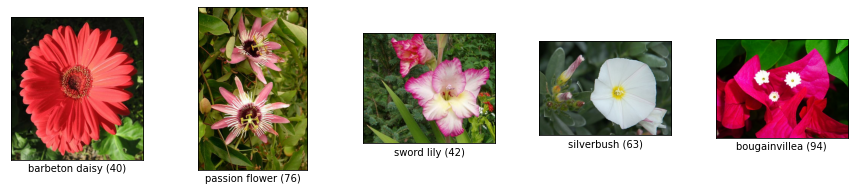

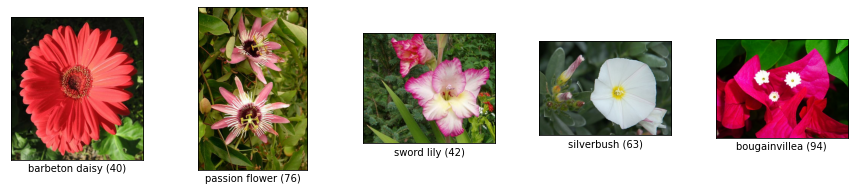

In [3]:
ds_name = 'oxford_flowers102'
splits = ['test', 'validation', 'train']
ds, info = tfds.load(ds_name, split = splits, with_info=True)
(train_examples, validation_examples, test_examples) = ds
print(f"Number of flower types {info.features['label'].num_classes}")
print(f"Number of training examples: {tf.data.experimental.cardinality(train_examples)}")
print(f"Number of validation examples: {tf.data.experimental.cardinality(validation_examples)}")
print(f"Number of test examples: {tf.data.experimental.cardinality(test_examples)}\n")

print('Flower types full list:')
print(info.features['label'].names)

tfds.show_examples(train_examples, info, rows=1, cols=5)

In [6]:
print(train_examples)
print(validation_examples)
print(test_examples)
validation_examples.element_spec

<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


{'file_name': TensorSpec(shape=(), dtype=tf.string, name=None),
 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

In [4]:
IMAG_SIZE = 224 # All images will be resized to 224x224
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMAG_SIZE, IMAG_SIZE))
  return  image, label

In [5]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name="oxford_flowers102",
    split=['train', 'validation', 'test'],
    with_info=True,
    as_supervised=True,
    batch_size=32
)

In [6]:
metadata.features["label"]
tf.compat.v1.data.get_output_shapes(raw_train)[1]

TensorShape([None])

# Normalization

In [7]:
train = raw_train.map(normalize_img)
validation = raw_validation.map(normalize_img)
test = raw_test.map(normalize_img)

In [8]:
metadata.splits["train"].num_examples

1020

In [12]:
module_selection = ("mobilenet_v2_100_224", 224) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 16 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [13]:
do_fine_tuning = True #@param {type:"boolean"}

In [14]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TF version: 2.9.2
Hub version: 0.12.0
GPU is available


In [15]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=metadata.features["label"].num_classes)
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 2,354,534
Non-trainable params: 34,112
_________________________________________________________________


In [16]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.5e-3), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:
# Unbatch datasets to avoid batch mismatch
train = train.unbatch().batch(BATCH_SIZE,drop_remainder=True).repeat().shuffle(512)
validation = validation.unbatch().batch(BATCH_SIZE,drop_remainder=True).repeat()

In [18]:
steps_per_epoch = metadata.splits["train"].num_examples / BATCH_SIZE 
validation_steps = metadata.splits["validation"].num_examples / BATCH_SIZE
EPOCHS = 40
hist = model.fit(
    x=train,
    epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
    validation_data=validation,
    validation_steps=validation_steps,
    verbose=2).history

Epoch 1/40
63/63 - 79s - loss: 3.0482 - accuracy: 0.4336 - val_loss: 2.8277 - val_accuracy: 0.3418 - 79s/epoch - 1s/step
Epoch 2/40
63/63 - 19s - loss: 0.9281 - accuracy: 0.8105 - val_loss: 1.5580 - val_accuracy: 0.6152 - 19s/epoch - 293ms/step
Epoch 3/40
63/63 - 15s - loss: 0.3503 - accuracy: 0.9551 - val_loss: 1.3960 - val_accuracy: 0.6514 - 15s/epoch - 235ms/step
Epoch 4/40
63/63 - 19s - loss: 0.1466 - accuracy: 0.9912 - val_loss: 0.9360 - val_accuracy: 0.7725 - 19s/epoch - 293ms/step
Epoch 5/40
63/63 - 15s - loss: 0.0979 - accuracy: 0.9990 - val_loss: 0.7950 - val_accuracy: 0.8047 - 15s/epoch - 233ms/step
Epoch 6/40
63/63 - 19s - loss: 0.0914 - accuracy: 1.0000 - val_loss: 0.7919 - val_accuracy: 0.8086 - 19s/epoch - 292ms/step
Epoch 7/40
63/63 - 19s - loss: 0.0882 - accuracy: 1.0000 - val_loss: 0.7658 - val_accuracy: 0.8252 - 19s/epoch - 293ms/step
Epoch 8/40
63/63 - 15s - loss: 0.0866 - accuracy: 1.0000 - val_loss: 0.7521 - val_accuracy: 0.8262 - 15s/epoch - 238ms/step
Epoch 9/40


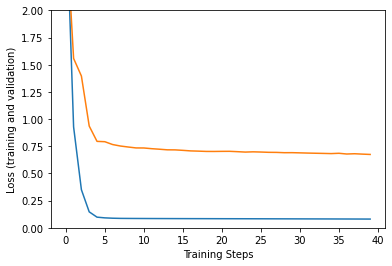

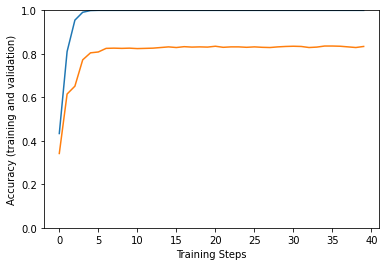

In [19]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [20]:
saved_model_path = "/tmp/saved_flowers_model"
tf.saved_model.save(model, saved_model_path)

In [21]:
class_names = np.array(metadata.features['label'].names)
print(class_names)


['pink primrose' 'hard-leaved pocket orchid' 'canterbury bells'
 'sweet pea' 'english marigold' 'tiger lily' 'moon orchid'
 'bird of paradise' 'monkshood' 'globe thistle' 'snapdragon' "colt's foot"
 'king protea' 'spear thistle' 'yellow iris' 'globe-flower'
 'purple coneflower' 'peruvian lily' 'balloon flower'
 'giant white arum lily' 'fire lily' 'pincushion flower' 'fritillary'
 'red ginger' 'grape hyacinth' 'corn poppy' 'prince of wales feathers'
 'stemless gentian' 'artichoke' 'sweet william' 'carnation' 'garden phlox'
 'love in the mist' 'mexican aster' 'alpine sea holly'
 'ruby-lipped cattleya' 'cape flower' 'great masterwort' 'siam tulip'
 'lenten rose' 'barbeton daisy' 'daffodil' 'sword lily' 'poinsettia'
 'bolero deep blue' 'wallflower' 'marigold' 'buttercup' 'oxeye daisy'
 'common dandelion' 'petunia' 'wild pansy' 'primula' 'sunflower'
 'pelargonium' 'bishop of llandaff' 'gaura' 'geranium' 'orange dahlia'
 'pink-yellow dahlia?' 'cautleya spicata' 'japanese anemone'
 'black-eye

In [22]:
CLASS_NAMES = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"]
output_class_names = np.array(CLASS_NAMES)

In [23]:
image_batch, label_batch = next(iter(train))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

1/1 [==============================] - 0s 439ms/step
['monkshood' 'snapdragon' 'blackberry lily' 'spear thistle' 'bearded iris'
 'spring crocus' 'hard-leaved pocket orchid' 'clematis' 'daffodil'
 'pink primrose' 'rose' 'bougainvillea' 'ball moss'
 'prince of wales feathers' 'gaura' 'garden phlox']


In [24]:
predicted_output_class_names = output_class_names[predicted_ids]
print(predicted_output_class_names)

['monkshood' 'snapdragon' 'blackberry lily' 'spear thistle' 'bearded iris'
 'spring crocus' 'hard-leaved pocket orchid' 'clematis' 'daffodil'
 'pink primrose' 'rose' 'bougainvillea' 'ball moss'
 'prince of wales feathers' 'gaura' 'garden phlox']


In [25]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [  8  10 101  13  67  66   1  81  41   0  73  94  92  26  56  31]
Predicted labels:  [  8  10 101  13  67  66   1  81  41   0  73  94  92  26  56  31]


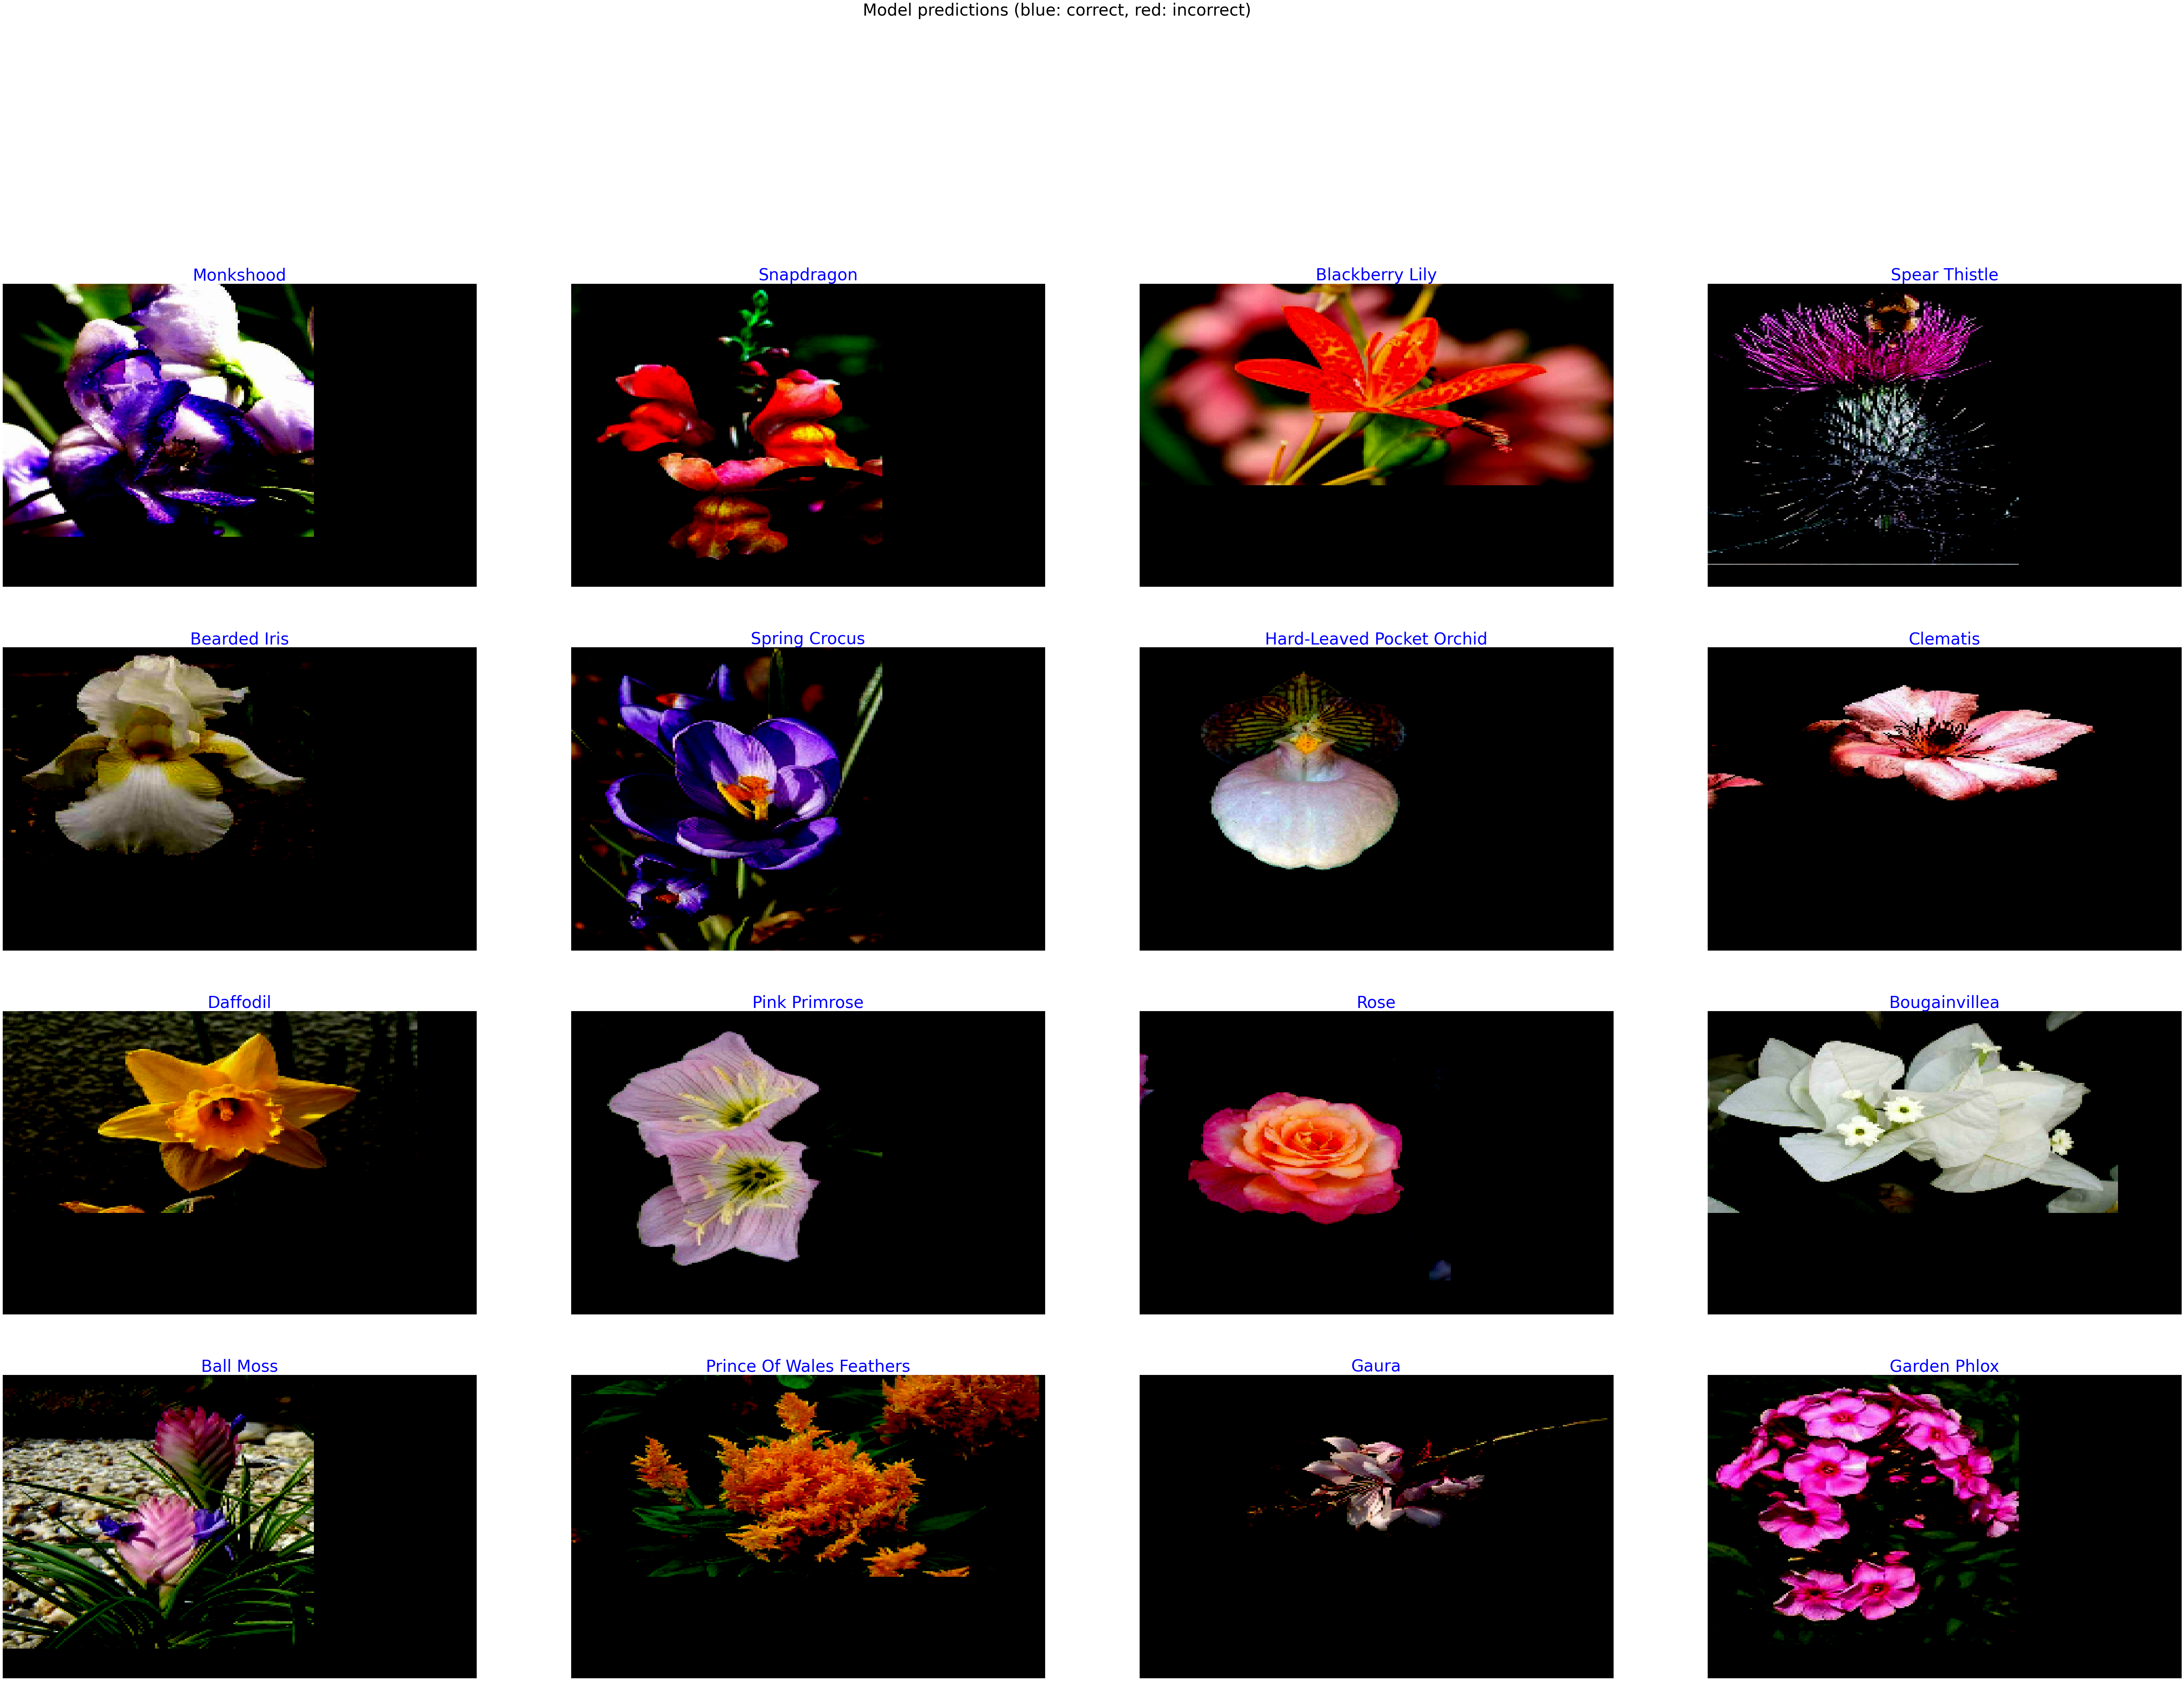

In [26]:
plt.figure(figsize=(100,100))
for n in range(BATCH_SIZE):
  plt.subplot(6,4,n+1)
  plt.imshow(image_batch[n], aspect='auto', extent=plt.axis())
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_output_class_names[n].title(), color=color,size=42)
  plt.axis('off')
  plt.suptitle("Model predictions (blue: correct, red: incorrect)",size=42)

In [27]:
saved_model_path = "/tmp/saved_model"
tf.saved_model.save(model,saved_model_path)
!saved_model_cli show --dir $saved_model_path --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 102)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


# Fine Tuning

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline 

from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
#from keras.preprocessing import image
from keras.applications.resnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
train_folder = '/content/drive/My Drive/flower/dataset/train'

image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical',
    subset='training'
    )
validation_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical',
    subset='validation'
    )

Found 5283 images belonging to 102 classes.
Found 1269 images belonging to 102 classes.


In [16]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = MobileNetV2(input_shape=IMG_SHAPE, input_tensor=None,
                                                include_top=False, 
                                                weights='imagenet')
base_model.trainable = True
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(102, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy'])

In [17]:
# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)
#fit the model
history = model.fit(train_generator, 
                    epochs=10,
                    validation_data = validation_generator,
                    callbacks=[early_stopper, reduce_lr])

Epoch 1/10
221/221 [==============================] - 1530s 7s/step - loss: 4.0435 - accuracy: 0.1501 - val_loss: 3.7042 - val_accuracy: 0.1868 - lr: 0.0010
Epoch 2/10
221/221 [==============================] - 114s 517ms/step - loss: 2.2313 - accuracy: 0.5007 - val_loss: 2.1330 - val_accuracy: 0.4673 - lr: 0.0010
Epoch 3/10
221/221 [==============================] - 117s 528ms/step - loss: 1.0797 - accuracy: 0.7409 - val_loss: 1.1498 - val_accuracy: 0.7179 - lr: 0.0010
Epoch 4/10
221/221 [==============================] - 119s 539ms/step - loss: 0.6113 - accuracy: 0.8427 - val_loss: 0.7728 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 5/10
221/221 [==============================] - 121s 549ms/step - loss: 0.4013 - accuracy: 0.9002 - val_loss: 0.5101 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 6/10
221/221 [==============================] - 119s 539ms/step - loss: 0.2760 - accuracy: 0.9290 - val_loss: 0.4021 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 7/10
221/221 [============================

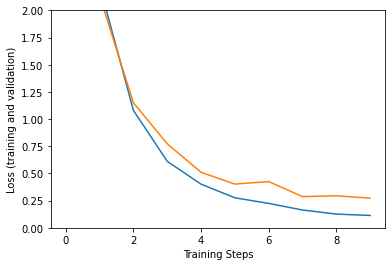

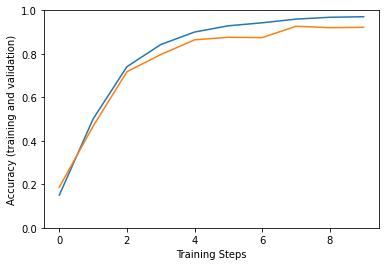

In [20]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])